# Sparkify Project: Predicting At-Risk Users

# Project Overview

Sparkify is a music streaming app facing a critical challenge: identifying at-risk users who are likely to cancel their subscription. Like many businesses, retaining users is essential for Sparkify's growth and profitability. By identifying these users early, Sparkify can implement targeted promotions to increase retention and ultimately boost revenue.

In this project, we leverage user event data from the Sparkify app to build a machine learning model that predicts at-risk users. The dataset includes key information such as:

* User Profile: User ID, name, gender, location, subscription level, etc.
* User Behavior: Actions within the app (e.g., play song, downgrade, upgrade, cancel subscription, thumbs up/down), session details, song play time, and more.
* Timestamp: The time each event occurred.

**Strategy to predict At-Risk Users:**

* **Data Processing & Cleaning:** Remove invalid or missing data to ensure data quality.
* **Exploratory Data Analysis (EDA):** Analyze the data to uncover patterns and identify key features for prediction.
    * **Churn Definition:** Users who cancel their subscription are labeled as "churn" (1), while others are labeled as "non-churn" (0).
    * **Behavioral Analysis:** Compare behaviors between churned and non-churned users to select relevant features.
* **Feature Engineering:** Select and create the most predictive features for the model.
* **Modeling:** Test various machine learning models to find the best-performing one.
* **Evaluation:** Use the F1-score to evaluate model performance, ensuring a balance between precision and recall.

In [1]:
%%html
<style>
div.output_area pre {
    white-space: pre;
}
.container { 
    width:100% !important; 
}
</style>

In [2]:
# import libraries
import pandas as pd
import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import *
from pyspark.sql.types import  TimestampType
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.sql import Window

In [3]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("My Spark") \
    .config("spark.some.config.option", "spark_config") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
#load data and cast ts column to timestamp type.
df = spark.read.json("mini_sparkify_event_data.json").withColumn('timestamp', (F.col('ts')/1000).cast(TimestampType()))

In [5]:
df.show(10)

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|          timestamp|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|2018-10-01 00:01:57|
|    Five Ir

In [6]:
df.dtypes

[('artist', 'string'),
 ('auth', 'string'),
 ('firstName', 'string'),
 ('gender', 'string'),
 ('itemInSession', 'bigint'),
 ('lastName', 'string'),
 ('length', 'double'),
 ('level', 'string'),
 ('location', 'string'),
 ('method', 'string'),
 ('page', 'string'),
 ('registration', 'bigint'),
 ('sessionId', 'bigint'),
 ('song', 'string'),
 ('status', 'bigint'),
 ('ts', 'bigint'),
 ('userAgent', 'string'),
 ('userId', 'string'),
 ('timestamp', 'timestamp')]

In [7]:
# user and session check
def gen_count_check(df, column_name):
    user_check = df.agg(countDistinct(F.col(column_name)).alias('distinct_count'),
                    count(F.col(column_name)).alias('count_all'),
                   count(when(F.col(column_name).isNull(), F.col(column_name))).alias('null_count'),
                   count(when(F.col(column_name)=='', F.col(column_name))).alias('empty_count'), 
                   )
    return user_check.show()

In [8]:
col_check = ['userId', 'sessionId']
for col in col_check:
    print(f'Count Check for {col}:')
    gen_count_check(df, col)

Count Check for userId:
+--------------+---------+----------+-----------+
|distinct_count|count_all|null_count|empty_count|
+--------------+---------+----------+-----------+
|           226|   286500|         0|       8346|
+--------------+---------+----------+-----------+

Count Check for sessionId:
+--------------+---------+----------+-----------+
|distinct_count|count_all|null_count|empty_count|
+--------------+---------+----------+-----------+
|          2354|   286500|         0|          0|
+--------------+---------+----------+-----------+



##### Observation:
There are 8346 rows without a userId. Since identifying user behaviors is essential to our analysis, we will remove these rows as they don't provide useful information for our purpose. 

In [9]:
# Remove empty strings in userId column
df = df.filter(F.col('userId')!='')

# Exploratory Data Analysis

### Preliminary analysis

In [10]:
def col_count_check(df, column_name):
    group_df = df.groupBy(column_name).agg(count(column_name).alias('count_all'),
                                           count(when(F.col(column_name).isNull(), column_name)).alias('null_count'),
                                           count(when(F.col(column_name) == '', column_name)).alias('empty_count'),
                                           countDistinct('userId').alias('user_count'),
                                           countDistinct('sessionId').alias('session_count')
                                          )
    return group_df

In [11]:
# List of columns to check
col_check2 = ['gender', 'level', 'page']

# Loop through each column and run the count_check function
for col in col_check2:
    result = col_count_check(df, col)
    print(f"Results for column: {col}")
    result.show(100)

Results for column: gender
+------+---------+----------+-----------+----------+-------------+
|gender|count_all|null_count|empty_count|user_count|session_count|
+------+---------+----------+-----------+----------+-------------+
|     F|   154578|         0|          0|       104|         1437|
|     M|   123576|         0|          0|       121|         1198|
+------+---------+----------+-----------+----------+-------------+

Results for column: level
+-----+---------+----------+-----------+----------+-------------+
|level|count_all|null_count|empty_count|user_count|session_count|
+-----+---------+----------+-----------+----------+-------------+
| free|    55721|         0|          0|       195|         1168|
| paid|   222433|         0|          0|       165|         1648|
+-----+---------+----------+-----------+----------+-------------+

Results for column: page
+--------------------+---------+----------+-----------+----------+-------------+
|                page|count_all|null_coun

In [12]:
user_check = df.agg(countDistinct(F.col('userId')).alias('user_count'), 
                    countDistinct(when(F.col('page')=='Cancellation Confirmation', F.col('userId'))).alias('churned_user')
                   )

user_check = user_check.withColumn('churn_rate', round((F.col('churned_user')/F.col('user_count'))*100, 2))
user_check.show()

+----------+------------+----------+
|user_count|churned_user|churn_rate|
+----------+------------+----------+
|       225|          52|     23.11|
+----------+------------+----------+



#### Observation

##### Data Overview:
The dataset contains information on 225 users, split into 104 female and 121 male users.

Out of these users, 52 have experienced a cancellation confirmation event, leading to a churn rate of approximately 23%.

The subset includes 195 free users and 165 paid users, indicating that some users have either upgraded or downgraded their service level during this period.

##### User Behavior:
The 'page' column in the data tracks the users' behavior within the app, representing the actions or events users trigger. Since some events are very similar (e.g., Settings and Save Settings), we will clean and group these events into categories to simplify the analysis. The events are grouped into negative, positive, and neutral experiences based on their impact on the user experience:

**Negative Experience:**

These events suggest dissatisfaction or issues faced by users:

* Downgrade Actions: Submit Downgrade and Downgrade will be grouped into a single category called 'Downgrade', which captures users' intentions or actions to reduce their service level.

* Cancel: Users clicked the Cancel button, which may or may not lead to a confirmed cancellation.

* Cancellation Confirmation: This event confirms the user's intent to cancel their subscription.

* Roll Advert: Indicates that users encountered advertisements during music streaming.

* Help/Error: Help and Error will be grouped into 'Help', which reflects issues or errors that prompted users to seek support from the app.

**Positive Experience:**
These events reflect positive engagement or satisfaction:

* Upgrade Actions: Upgrade and Submit Upgrade will be grouped into 'Upgrade', representing users' intention or action to move to a higher service level.
* Add Friend: Users added friends to their network.
* NextSong: Users played the next song in their playlist, indicating ongoing engagement.
* Thumbs Up: Users gave positive feedback on songs, suggesting content enjoyment.

**Neutral Experience:**
These events represent routine actions with no clear positive or negative implications:

* Settings/Save Settings: Save Settings and Settings will be grouped into 'Settings', indicating that users made adjustments to their app configurations.
* Logout: Users logged out of the app.
* Home: Users returned to or accessed the home screen.
* About: Users visited the About page of the app

In [13]:
re_class_page = df.withColumn('page', when(F.col('page')=='Submit Downgrade', lit('Downgrade')).\
                              when(F.col('page')=='Save Settings', lit('Settings')).\
                              when(F.col('page')=='Error', lit('Help')).\
                              when(F.col('page')=='Submit Upgrade', lit('Upgrade')).
                                   otherwise(F.col('page')))

In [14]:
col_count_check(re_class_page, 'page').show()

+--------------------+---------+----------+-----------+----------+-------------+
|                page|count_all|null_count|empty_count|user_count|session_count|
+--------------------+---------+----------+-----------+----------+-------------+
|              Cancel|       52|         0|          0|        52|           52|
|         Thumbs Down|     2546|         0|          0|       203|         1133|
|                Home|    10082|         0|          0|       223|         2072|
|           Downgrade|     2118|         0|          0|       154|          884|
|         Roll Advert|     3933|         0|          0|       207|          991|
|              Logout|     3226|         0|          0|       213|         1416|
|Cancellation Conf...|       52|         0|          0|        52|           52|
|               About|      495|         0|          0|       155|          404|
|            Settings|     1824|         0|          0|       195|          843|
|     Add to Playlist|     6

### Churn definition
We will use event `Cancellation Confirmation` to determin churn users. If users ever has this event, they are churn (1), otherwise, they are not churn (0).

In [15]:
# select churn user and label them as 1 in churn column
cancellation = df.filter(F.col('page')=='Cancellation Confirmation').select('userId').distinct().withColumn('churn', lit(1))

In [16]:
# join churn users with orginal dataframe and label other users with 0 (non-churn)
df = df.join(cancellation, on = 'userId', how = 'left').fillna({'churn': 0})

### Explore Churned vs non-churned users behaviors
In this section, we will explore the behaviors of churn and non-churn users in the app by examining the following key metrics:

**1/ visit Rate:** This metric represents how often users visit a particular page relative to their total activity in the app.

$$
\text{visit_rate} = \frac{\text{visit_times}}{\text{total_visit}}
$$
 
Where:
* **visit_times:** The total number of events where the user visits the specific page.
* **total_visit:** The total number of events recorded for the user across the app.

**2/ session_num**: Total number of sessions, this metric captures the total number of sessions a user has within the app. A session is defined as a continuous period of user activity in the app.

**3/ avg_item:** Average Items per Session, this measures the average number of items or actions (events) a user performs within a session.

**4/ avg_length:** Average Song Play Duration, This metric calculates the average duration for which a user plays a song during their interactions with the app.

**Visualization Plan:**

**Histograms:**

We will use histograms to visualize the distribution of the following metrics across all users to detect any abnormalities or patterns:

* session_num (number of sessions)
* avg_item (average number of items per session)
* avg_length (average song play duration)

**Boxplots:**

Boxplots will be used to compare the distribution of the above metrics between churn and non-churn users. This will help us understand whether there are significant differences in behavior that might explain why some users churn while others do not.

In [17]:
# list of column to fill with 0 after pivoting
page_list = ['Cancel', 'Thumbs Down', 'Home', 'Downgrade', 'Roll Advert', 'Logout', 'About', 'Settings', 'Add to Playlist', 
             'Add Friend', 'NextSong', 'Thumbs Up', 'Help', 'Upgrade', 'Cancellation Confirmation']

In [19]:
# count number of visits per page per user
visit_page = re_class_page.groupBy('page', 'userId').agg(count('userId').alias('visit_times')).fillna({'visit_times':0})

# count total events (visits) of users
total_visit = re_class_page.groupBy('userId').agg(count('userId').alias('total_visit')).fillna({'total_visit':0})

# calculate visit rate
visit_rate = visit_page.join(total_visit, on = 'userId', how = 'inner').\
                        withColumn('visit_rate', F.col('visit_times')/F.col('total_visit'))

# transpose page column to rows
visit_rate_pivot = visit_rate.groupBy('userId').pivot('page').agg(avg('visit_rate')).fillna(0, subset=page_list)

In [ ]:
visit_rate_pivot.show()

In [20]:
# Calculate the number of sessions, average of items in sessions and average song duration.
agg_df = df.groupBy('userId', 'churn').agg(countDistinct('sessionId').alias('session_num'),
                                                    avg('itemInSession').alias('avg_item'),
                                                    avg(when(F.col('length').isNotNull(), F.col('length'))).alias('avg_length')
                                          )

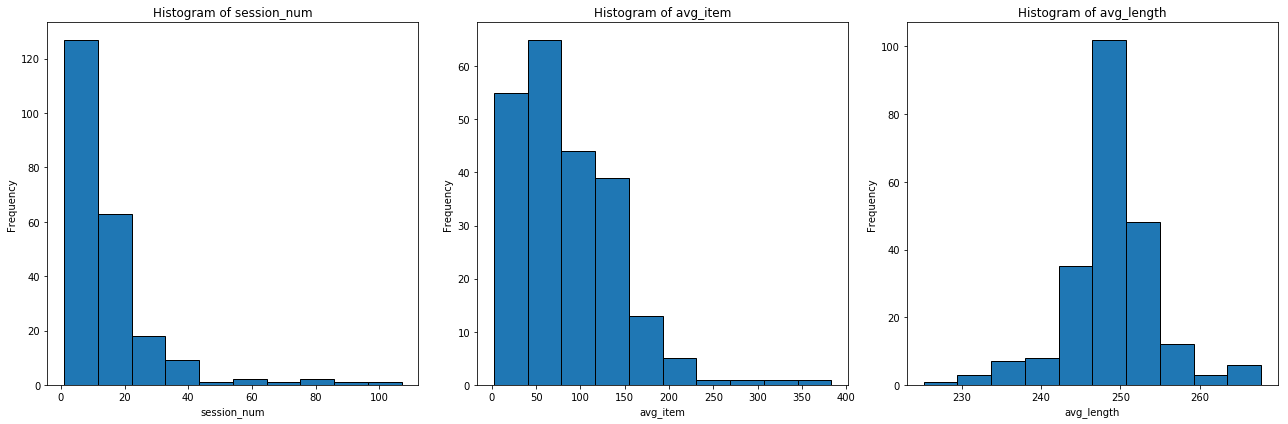

In [21]:
# Create histogram chart to observe distrubtion of metric in agg_df
# Convert spark dataframe to Pandas dataframe for visualization
agg_df_pd = agg_df.toPandas()

# Create a figure with 1 row and 3 subplots (side by side)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Loop through the first 3 columns (excluding the first 2)
for i, col in enumerate(agg_df_pd.columns[2:5]):
    axes[i].hist(agg_df_pd[col], bins=10, edgecolor='black')
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(f'{col}')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()

plt.show()

#### Observation:
No abnormal data

In [22]:
# join all metrics together
user_agg_df = agg_df.join(visit_rate_pivot, on = 'userId', how ='left').fillna(0, subset=page_list)
user_agg_df.show(5)

+------+-----+-----------+------------------+------------------+--------------------+--------------------+--------------------+--------------------+-------------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|userId|churn|session_num|          avg_item|        avg_length|               About|          Add Friend|     Add to Playlist|              Cancel|Cancellation Confirmation|           Downgrade|                Help|                Home|              Logout|          NextSong|         Roll Advert|            Settings|         Thumbs Down|           Thumbs Up|             Upgrade|
+------+-----+-----------+------------------+------------------+--------------------+--------------------+--------------------+--------------------+-------------------------+--------------------+--------------------+------------------

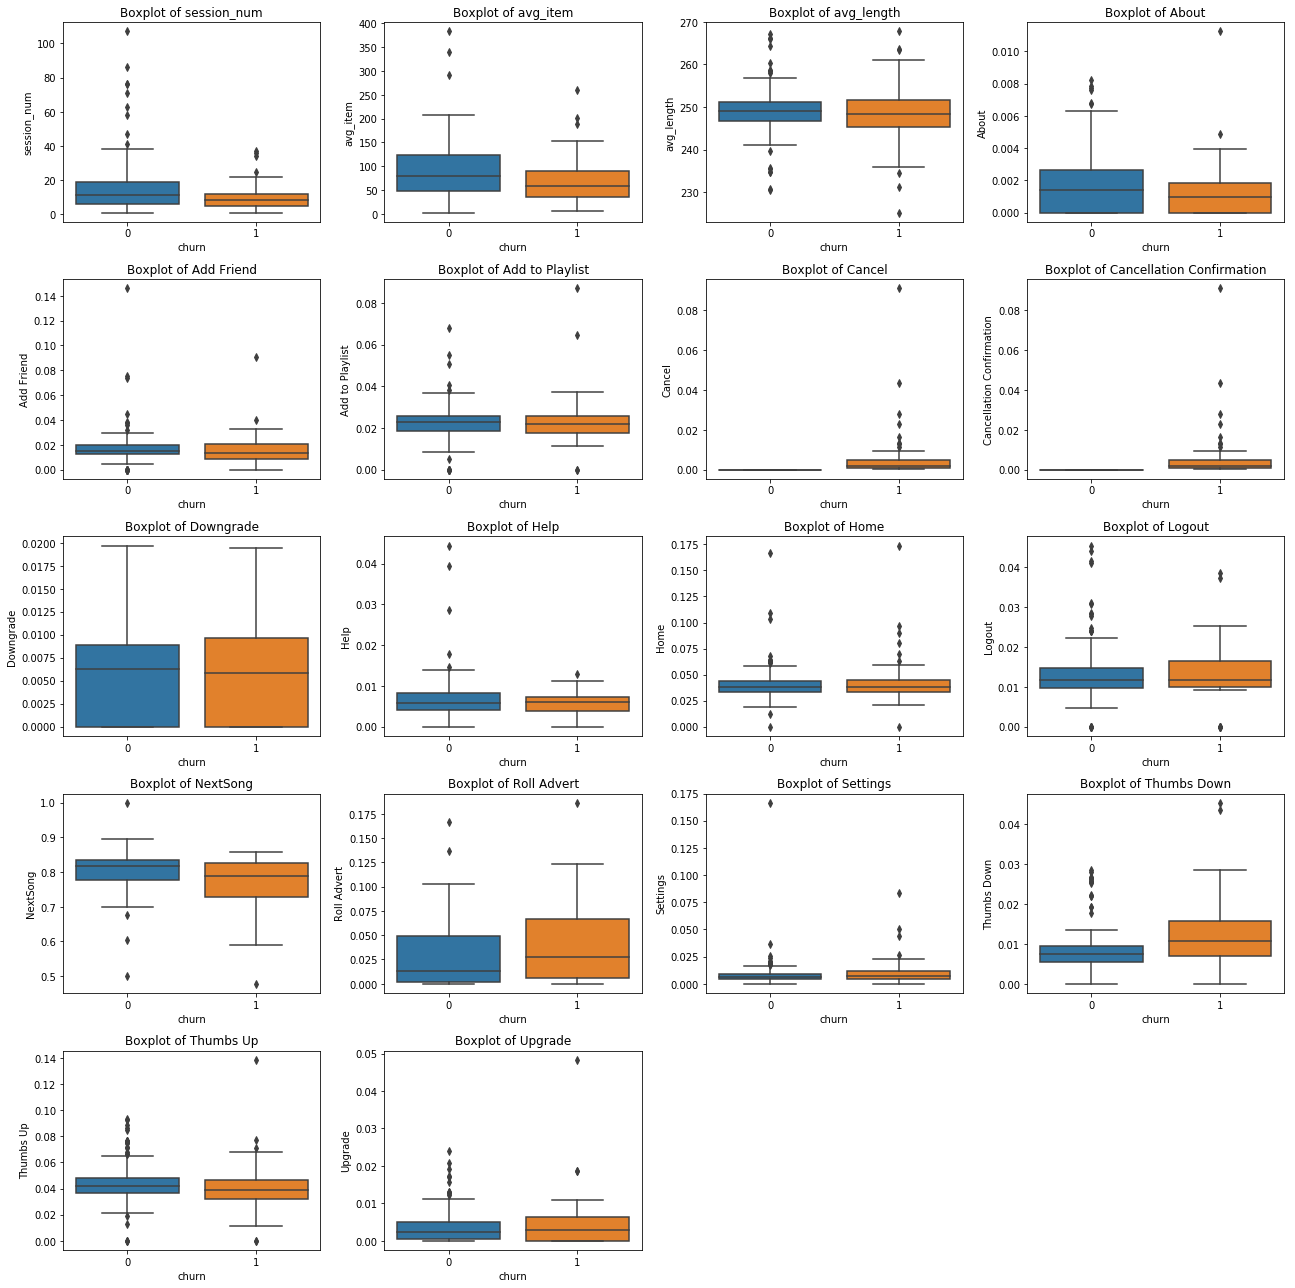

In [23]:
# Create boxlot chart to observe distrubtion of metric in user_agg_df
# Convert spark dataframe to Pandas dataframe for visualization
user_agg_pd = user_agg_df.toPandas()

fig, axes = plt.subplots(5, 4, figsize=(18, 18))

axes = axes.flatten()

# Loop through all columns, starting from index 2
for i, col in enumerate(user_agg_pd.columns[2:]):
    sns.boxplot(data=user_agg_pd, x='churn', y=col, ax=axes[i])
    axes[i].set_title(f"Boxplot of {col}")

# Hide the last empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])


plt.tight_layout()

plt.show()

#### Observation

From the boxplot analysis, we can observe the following trends:

Churn users tend to have fewer sessions and a lower average number of items per session compared to non-churn users.

Additionally, churn users appear to encounter more negative experiences in the app, including:
* Downgrade events
* Thumbs Down (negative feedback on songs)
* Roll Advert (ads experienced during music playback)
* Logout events (indicating less engagement)

# Feature Engineering

Based on these observations, we will select the following features for our model:

* session_num (total number of sessions)
* avg_item (average number of items per session)
* Downgrade (whether the user downgraded their service level)
* Thumbs Down (negative feedback events)
* Logout (indicating users logging out of the app)
* Roll Advert (whether the user experienced ads)

Since these features have already been cleaned and processed during the exploratory data analysis (EDA) stage, we can proceed directly to selecting these features for model training.

In addition to behavioral data, we will incorporate user profile information, such as gender and subscription level, into our model. Since these are categorical features, they need to be properly processed before being used in the model.

**Processing Strategy:**

We will use OneHotEncoder to transform categorical columns (gender and level), ensuring the model can handle different categories effectively. OneHotEncoding is particularly useful because it allows the model to scale efficiently, especially when applied to large datasets with multiple categories.

**Subscription Level:**

As mentioned earlier, users can change their subscription level over time (e.g., switching from free to paid). To account for this dynamic behavior and avoid duplication in the final dataset, we will follow these steps:

* **Track Subscription Changes Over Time:** We will monitor how users' subscription levels change over the course of their activity. This feature can provide valuable insight into churn behavior, as frequent changes may correlate with churn risk.

* **Capture the Most Recent Subscription Level:** To prevent duplication and ensure each user has a single entry in the model, we will record the most recent subscription level for each user. This gives us a snapshot of the user's status at the end of the observation period, which is crucial for predicting future churn behavior.

In [26]:
# process gender data: convert categorical to numeric
gender_df = df.select('userId', 'gender').distinct()

gender_indexer = StringIndexer(inputCol="gender", outputCol="gender_index")

# One-hot encode the indexed gender column
gender_encoder = OneHotEncoder(inputCol="gender_index", outputCol="gender_encoded")

# Create a pipeline to apply transformations
gender_pipeline = Pipeline(stages=[gender_indexer, gender_encoder])

# Apply the transformations to the DataFrame
gender_df_transform = gender_pipeline.fit(gender_df).transform(gender_df).select('userId', 'gender_encoded').distinct()

In [ ]:
gender_df_transform.show(5)

In [27]:
# Index the subscription level column
subscription = df.select('userId', 'level', 'timestamp').distinct()
subscription_indexer = StringIndexer(inputCol="level", outputCol="subscription_index")

# One-hot encode the indexed subscription level
subscription_encoder = OneHotEncoder(inputCol="subscription_index", outputCol="subscription_encoded")

# Create a pipeline for subscription level transformations
subscription_pipeline = Pipeline(stages=[subscription_indexer, subscription_encoder])

# Apply the pipeline to the data
level_df = subscription_pipeline.fit(subscription).transform(subscription)


# Define a window partitioned by user_id and ordered by time 
window_spec = Window.partitionBy("userId").orderBy("timestamp")

# Use lag to get the previous subscription level
level_df = level_df.withColumn("prev_subscription_level", lag("level").over(window_spec))

# Create a new column 'subscription_change' that indicates whether the user changed their subscription level
level_df = level_df.withColumn(
    "subscription_change",
    when(col("level") != col("prev_subscription_level"), 1).otherwise(0)
)

# Calculate total number of subscription changes per user
subscription_changes = level_df.groupBy("userId").agg(sum("subscription_change").alias("total_subscription_changes"))

# Add a row number based on the most recent timestamp for each user
level_with_rownum = level_df.withColumn("row_num", row_number().over(window_spec))

# Filter to get only the most recent row for each user
level_select = level_with_rownum.filter(col("row_num") == 1).select('userId', 'subscription_encoded').distinct()

In [28]:
# Join all features together
all_features = user_agg_df.join(gender_df_transform, on = 'userId', how ='left').\
                           join(level_select, on = 'userId', how = 'left').\
                           join(subscription_changes, on ='userId', how = 'left')

In [29]:
# select final features
final_features = all_features.select('userId', 'churn', 'session_num', 'avg_item', 'Downgrade', 
                                     'Thumbs Down', 'Logout', 'Roll Advert', 'gender_encoded', 'subscription_encoded','total_subscription_changes')

In [ ]:
final_features.show(4)

# Modeling

Since this is a classification problem, we will use Logistic Regression and Random Forest Classifier to test and evaluate the performance of different models.

* Logistic Regression is a well-known and widely used model for binary classification tasks due to its simplicity, interpretability, and ability to provide probabilistic outcomes. It is effective when the relationship between the features and the target variable is approximately linear.

* Random Forest Classifier is chosen because it is a powerful ensemble method that combines multiple decision trees, which helps in reducing overfitting and improving generalization. It is especially useful for capturing complex, non-linear relationships and can handle both categorical and continuous variables well.

To improve model performance, we will use Grid Search for hyperparameter tuning, which allows us to systematically explore different parameter combinations to find the best configuration for each model.

Finally, we will determine the best model based on the F1-score metric. The F1-score is a good choice here because we are dealing with an imbalanced dataset (with a focus on non-churned users), and it balances precision and recall, making it more suitable for evaluating performance in this context than accuracy alone.

### Prepare features and split train, test data

In [30]:
# Split the data into training and test sets (70% training and 30% testing)
train_data, test_data = final_features.randomSplit([0.7, 0.3], seed=42)

In [ ]:
train_data.show(5)

In [31]:
# Prepare the feature vector using VectorAssembler
assembler = VectorAssembler(inputCols=['session_num', 'avg_item', 'Downgrade', 'Thumbs Down', 'Logout', 'Roll Advert',
                                       'gender_encoded', 'subscription_encoded','total_subscription_changes'], 
                            outputCol='features')

### LogistricRegression Model

In [32]:
lr = LogisticRegression(labelCol='churn', featuresCol='features')

# Build a pipeline with feature assembler and the classifier
lr_pipeline = Pipeline(stages=[assembler, lr])

# Cross-validation with hyperparameter tuning
paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .build()

# Initialize the cross-validator
crossval_lr = CrossValidator(estimator=lr_pipeline,
                          estimatorParamMaps=paramGrid_lr,
                          evaluator=MulticlassClassificationEvaluator(labelCol='churn', predictionCol='prediction', metricName='f1'),
                          numFolds=5)

# Fit the model using cross-validation
cvModel_lr = crossval_lr.fit(train_data)

# Make predictions on the test set
predictions_lr = cvModel_lr.transform(test_data)

# Evaluate the model using F1-Score
f1_evaluator_lr = MulticlassClassificationEvaluator(labelCol='churn', predictionCol='prediction', metricName='f1')
f1_score_lr = f1_evaluator_lr.evaluate(predictions_lr)

# Output the F1-Score
print(f"F1 Score: {f1_score_lr}")

# View predictions DataFrame (to see predicted labels, probabilities)
predictions_lr.select('userId', 'churn', 'prediction', 'probability').show(10)

F1 Score: 0.6489772819144636
+------+-----+----------+--------------------+
|userId|churn|prediction|         probability|
+------+-----+----------+--------------------+
|200002|    0|       0.0|[0.58730397002372...|
|    51|    1|       0.0|[0.81779017179471...|
|    15|    0|       0.0|[0.81122708312905...|
|100014|    1|       0.0|[0.79971546706889...|
|    11|    0|       0.0|[0.79512649822435...|
|300017|    0|       0.0|[0.97816681381714...|
|100021|    1|       0.0|[0.58440177093977...|
|   112|    0|       0.0|[0.76562602436711...|
|    42|    0|       0.0|[0.91715667915528...|
|    87|    1|       0.0|[0.92770251466843...|
+------+-----+----------+--------------------+
only showing top 10 rows



### RandomForestClassifier Model

In [33]:
rf = RandomForestClassifier(labelCol='churn', featuresCol='features', numTrees=50)
rf_pipeline = Pipeline(stages=[assembler, rf])

# Cross-validation with Random Forest
paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100]) \
    .build()

crossval_rf = CrossValidator(estimator=rf_pipeline,
                          estimatorParamMaps=paramGrid_rf,
                          evaluator=MulticlassClassificationEvaluator(labelCol='churn', predictionCol='prediction', metricName='f1'),
                          numFolds=5)

# Fit the model using cross-validation
cvModel_rf = crossval_rf.fit(train_data)

# Make predictions on the test set
predictions_rf = cvModel_rf.transform(test_data)

# Evaluate the model using F1-Score
f1_evaluator_rf = MulticlassClassificationEvaluator(labelCol='churn', predictionCol='prediction', metricName='f1')
f1_score_rf = f1_evaluator_rf.evaluate(predictions_rf)

# Output the F1-Score
print(f"F1 Score: {f1_score_rf}")

#View predictions DataFrame (to see predicted labels, probabilities)
predictions_rf.select('userId', 'churn', 'prediction', 'probability').show(10)

F1 Score: 0.6258455522971652
+------+-----+----------+--------------------+
|userId|churn|prediction|         probability|
+------+-----+----------+--------------------+
|200002|    0|       1.0|[0.48971568180914...|
|    51|    1|       0.0|[0.75949206496284...|
|    15|    0|       0.0|[0.88011189950795...|
|100014|    1|       0.0|[0.77917738665068...|
|    11|    0|       0.0|[0.79616113004785...|
|300017|    0|       0.0|[0.85169399504516...|
|100021|    1|       1.0|[0.48162965577420...|
|   112|    0|       0.0|[0.73463355125997...|
|    42|    0|       0.0|[0.85206629914656...|
|    87|    1|       0.0|[0.88800502072520...|
+------+-----+----------+--------------------+
only showing top 10 rows



### Evaluation 
Based on the model evaluation, the LogisticRegressionachieved a higher F1-score (0.648) compared to the RandomForestClassifier model, which had an F1-score of 0.625. Therefore, we will select the RandomForestClassifier as the model for predicting churn.

However, an F1-score of 0.648 suggests that there is still room for improvement. Potential strategies for enhancing the model's performance will be discussed in the Limitations and Future Improvements section.

# Limitations and Future Improvements

**1/ Limited Dataset Size**

The model was trained on a relatively small subset of user data. With only 225 users, it may not fully capture the diversity of user behaviors, which can affect the model's generalization to a broader audience. A small dataset can lead to overfitting, where the model performs well on this specific data but struggles with new, unseen data.

**Improvement:**

Expanding the dataset to include more users and a longer time frame of activity would provide a richer and more representative sample. This could help the model learn more nuanced patterns and behaviors, potentially improving performance.

**2/ Feature Selection**

The features selected for the model are based on observed behavioral trends (e.g., session numbers, downgrades, thumbs down) and user demographic information (eg, gender, level of subscription) but these may not fully capture all the factors contributing to user churn. There could be other important variables—such as otehr user demographics, engagement frequency, or in-app spending—that were not included in this analysis.

**Improvement:**
Future iterations of the model should explore incorporating additional features such as:
Demographic data (age, location, etc.)
User engagement trends over time (e.g., daily/weekly activity levels)
Monetary behavior (e.g., in-app purchases)

This could improve the model's predictive power by giving it more information to work with.

**3/ Class Imbalance:**
While we used the F1-score to handle the imbalanced dataset, churn events are relatively rare in the data (23% churn rate). Imbalanced classes can lead the model to underperform in predicting the minority class (churn) because it is biased towards the majority class (non-churn).

**Improvement:**
Techniques such as oversampling the minority class (e.g., SMOTE), undersampling the majority class, or applying cost-sensitive learning could help address the class imbalance and improve the model’s ability to predict churn events more accurately.


**4/ Temporal Patterns:**
The current model does not account for changes in user behavior over time. Users might exhibit different behaviors as they approach churn (e.g., gradual disengagement), but this time-dependent information was not captured in the feature set.

**Improvement:**
Incorporating temporal features such as activity trends or time series data could help the model detect patterns leading up to churn more effectively. Recurrent Neural Networks (RNNs) or Long Short-Term Memory (LSTM) models could be considered for this purpose.